In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import arabic_reshaper
from bidi.algorithm import get_display

from keras import layers
from keras import models
from IPython import display
import librosa
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-02-13 17:14:32.325643: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 17:14:32.768408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 17:14:32.768886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 17:14:32.832232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 17:14:32.997065: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="quran/data_shuffled",
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 16219 files belonging to 9 classes.
Using 12976 files for training.
Using 3243 files for validation.


2024-02-13 17:14:56.114694: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 17:14:56.599826: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 17:14:56.599896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 17:14:56.605183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 17:14:56.605256: I external/local_xla/xla/stream_executor


label names: ['احمد الشلبي' 'اسماعيل القاضي' 'المنشاوي' 'زين ابو كوثر' 'طارق محمد'
 'عبد الباسط' 'علاء عقل' 'علاء ياسر' 'مختار الحاج']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [3]:
def stereo_to_mono_converter(example,labels):
    audio = example
    # If it has multiple channels, take the mean to convert to mono
    audio = tf.reduce_mean(audio, axis=-1, keepdims=True)
    # Add any additional preprocessing steps here
    return audio,labels


In [4]:
train_ds = train_ds.map(stereo_to_mono_converter, tf.data.AUTOTUNE)
val_ds = val_ds.map(stereo_to_mono_converter, tf.data.AUTOTUNE)

In [5]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [7]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


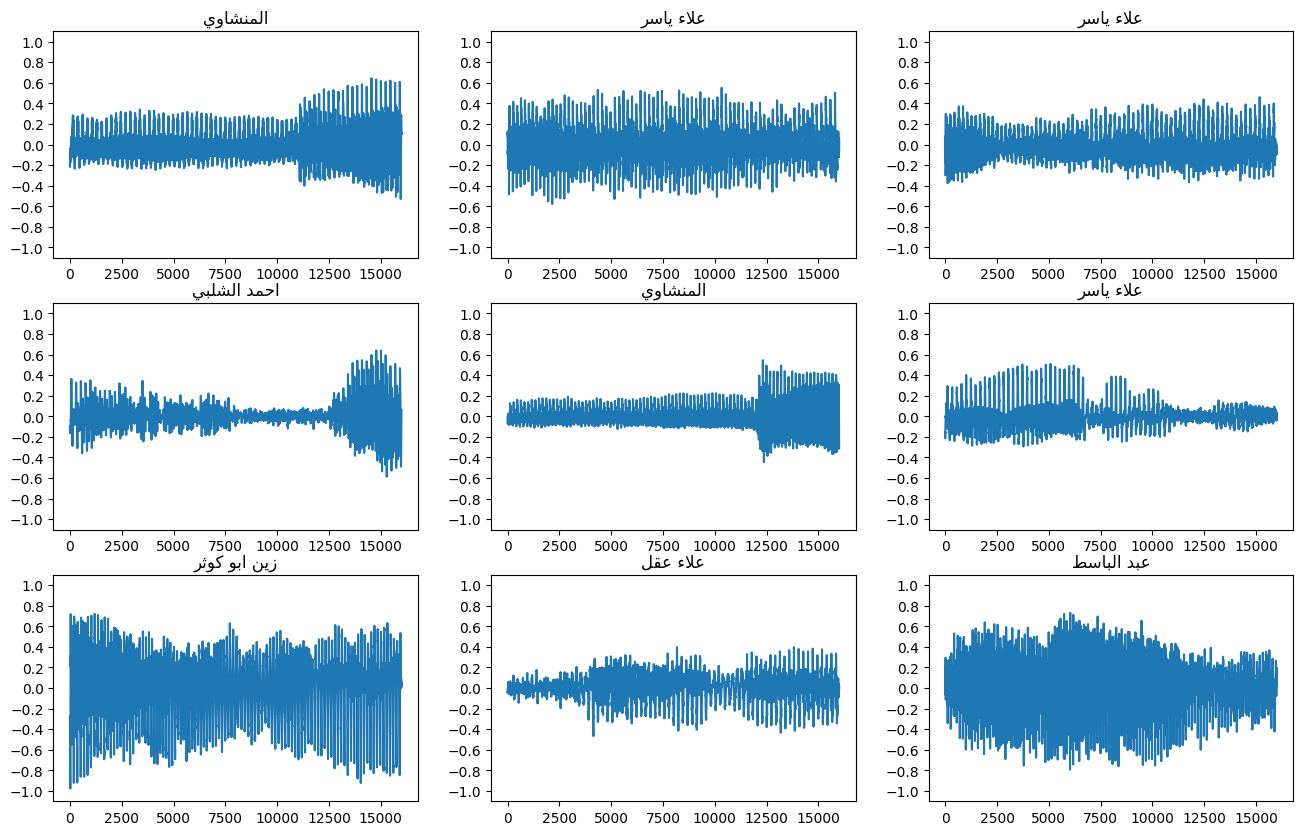

In [8]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(get_display(arabic_reshaper.reshape(label_names[example_labels[i]])))
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [9]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [13]:
for i in range(5):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: المنشاوي
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: علاء ياسر
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: علاء ياسر
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: احمد الشلبي
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: المنشاوي
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

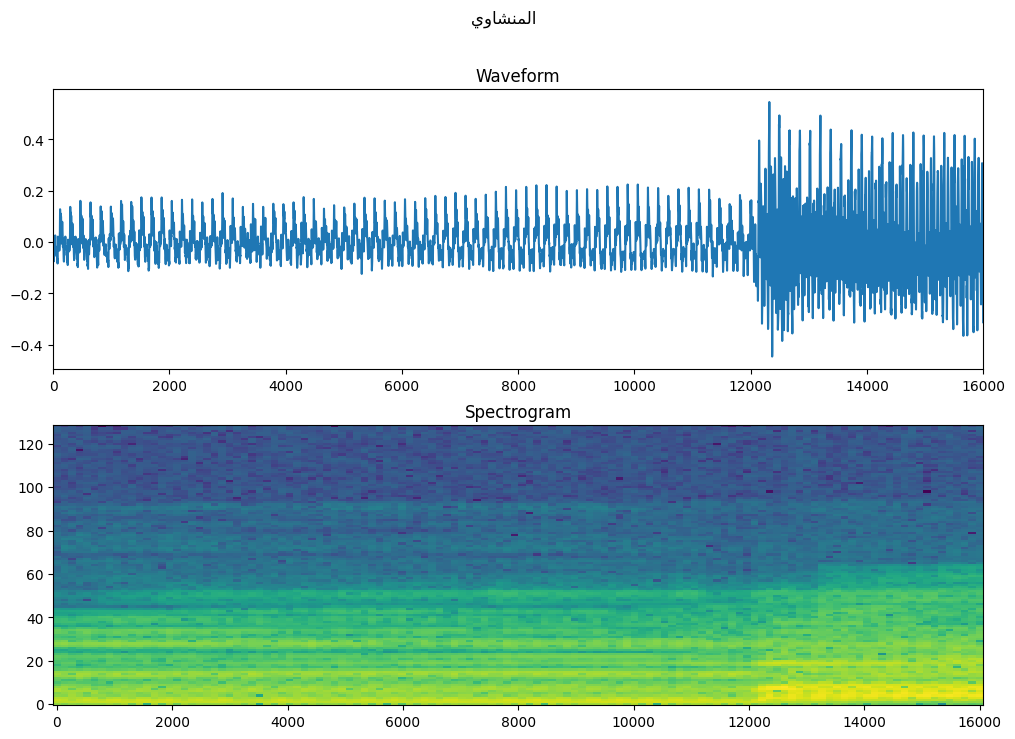

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(get_display(arabic_reshaper.reshape(label.title())))
plt.show()


Now, create spectrogram datasets from the audio datasets:

In [16]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [18]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

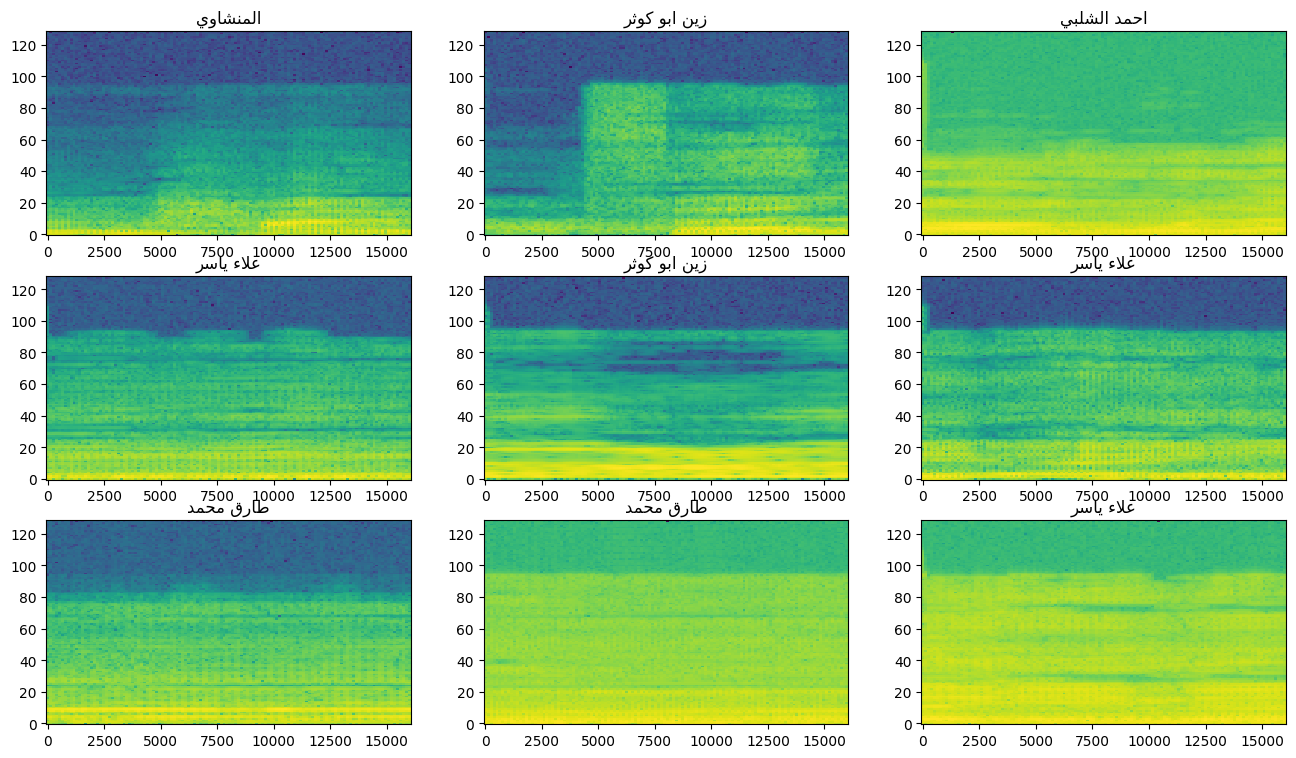

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(get_display(arabic_reshaper.reshape(label_names[example_spect_labels[i].numpy()])))

plt.show()

## Build and train the model

In [20]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)


norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [24]:
EPOCHS = 90
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/90


2024-02-13 17:16:53.036327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-13 17:16:53.513603: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-13 17:16:55.060104: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f91815ba7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-13 17:16:55.060153: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-02-13 17:16:55.142905: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707837415.402446 4025923 device_compiler.h:186] Compiled clust

203/203 [==============================] - 12s 36ms/step - loss: 1.2354 - accuracy: 0.5816 - val_loss: 0.6107 - val_accuracy: 0.8181
Epoch 2/90
203/203 [==============================] - 2s 10ms/step - loss: 0.7015 - accuracy: 0.7682 - val_loss: 0.4672 - val_accuracy: 0.8531
Epoch 3/90
203/203 [==============================] - 2s 9ms/step - loss: 0.5555 - accuracy: 0.8138 - val_loss: 0.3773 - val_accuracy: 0.8731
Epoch 4/90
203/203 [==============================] - 2s 9ms/step - loss: 0.4750 - accuracy: 0.8409 - val_loss: 0.3387 - val_accuracy: 0.8881
Epoch 5/90
203/203 [==============================] - 2s 9ms/step - loss: 0.4419 - accuracy: 0.8496 - val_loss: 0.3172 - val_accuracy: 0.8988
Epoch 6/90
203/203 [==============================] - 2s 8ms/step - loss: 0.3988 - accuracy: 0.8641 - val_loss: 0.2936 - val_accuracy: 0.8994
Epoch 7/90
203/203 [==============================] - 2s 9ms/step - loss: 0.3671 - accuracy: 0.8743 - val_loss: 0.2736 - val_accuracy: 0.8956
Epoch 8/90
203

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

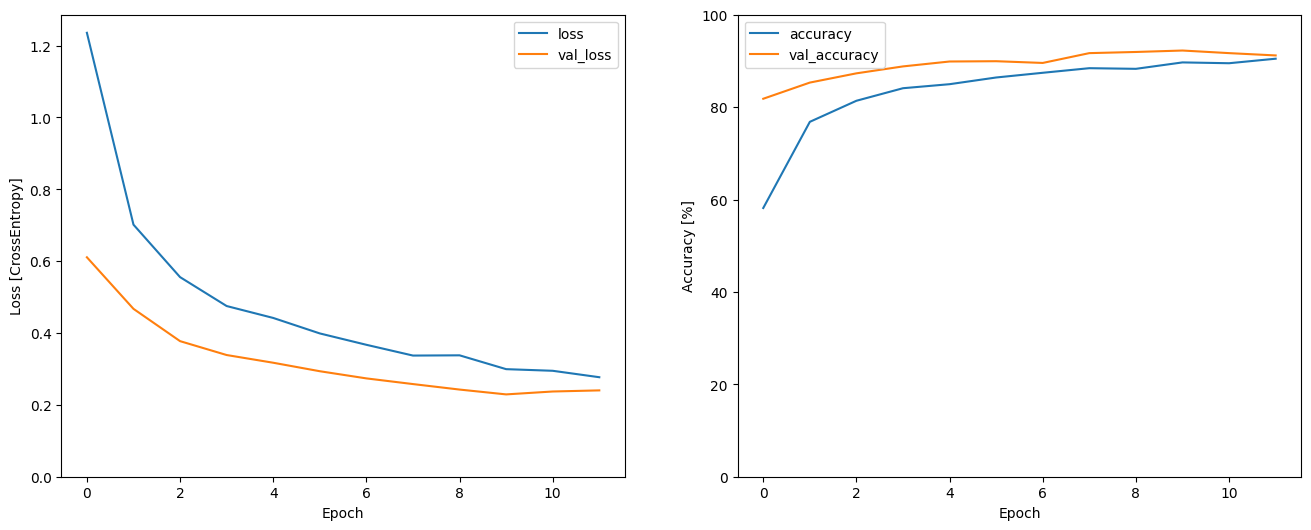

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

26/26 [==============================] - 5s 196ms/step - loss: 0.2856 - accuracy: 0.9038


{'loss': 0.28563931584358215, 'accuracy': 0.9038344621658325}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [27]:
y_pred = model.predict(test_spectrogram_ds)

26/26 [==============================] - 0s 3ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

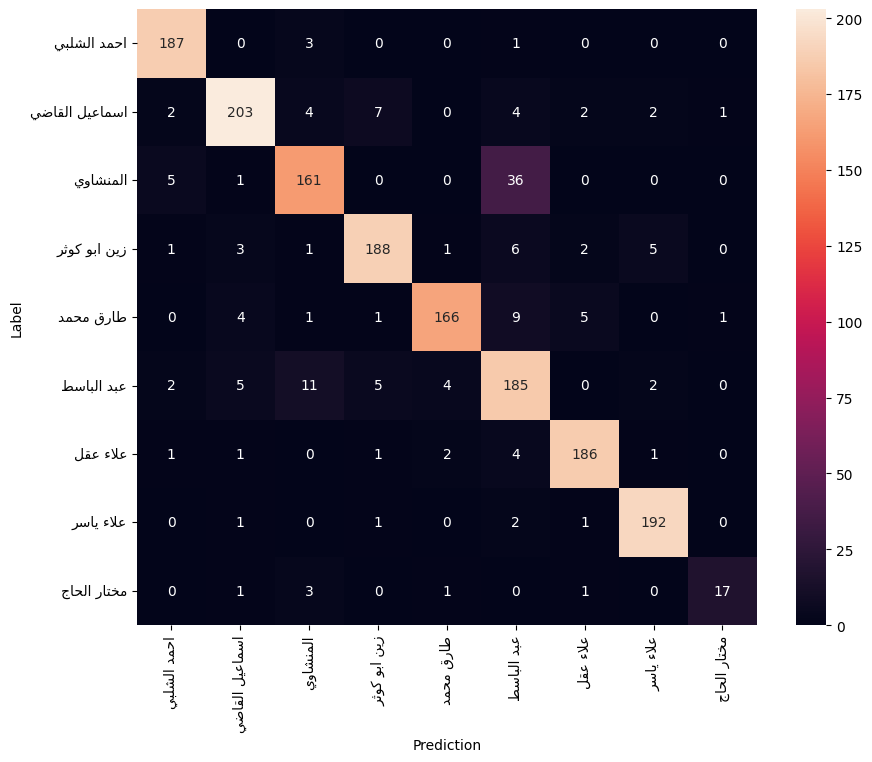

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# Convert label names to strings with reshaping
reshaped_label_names = [get_display(arabic_reshaper.reshape(label)) for label in label_names]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=reshaped_label_names, yticklabels=reshaped_label_names, annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

In [31]:
x = "test_examples/AHMAD.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
print(x.shape)
x = tf.squeeze(x, axis=-1)
# waveform = get_random_segment(x)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = sorted(os.listdir("quran/data_shuffled"))
label = tf.argmax(tf.nn.softmax(prediction[0]))
print(x_labels[label])

display.display(display.Audio(waveform, rate=16000))

(16000, 1)
احمد الشلبي


In [32]:
x = "test_examples/alaayass1.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)

x = tf.squeeze(x, axis=-1)
waveform=x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

prediction = model(x)
x_labels = sorted(os.listdir("quran/data_shuffled"))
label = tf.argmax(tf.nn.softmax(prediction[0]))
print(x_labels[label])

display.display(display.Audio(waveform, rate=16000))

علاء ياسر


## Export the model with preprocessing

In [33]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [34]:
export = ExportModel(model)
export(tf.constant(str("test_examples/alaayass1.wav")))

{'predictions': <tf.Tensor: shape=(1, 9), dtype=float32, numpy=
 array([[-12.978345  ,   5.9937277 ,  -7.854508  ,   0.27288222,
           1.9160509 ,   3.8474429 ,  -0.75542504,   7.1387324 ,
          -8.240251  ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([7])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=
 array([b'\xd8\xb9\xd9\x84\xd8\xa7\xd8\xa1 \xd9\x8a\xd8\xa7\xd8\xb3\xd8\xb1'],
       dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [35]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
pred = imported("test_examples/AHMAD.wav")
class_names=pred['class_names']
class_id=np.argmax(pred['class_ids'])
final_pred=class_names[class_id]

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


In [36]:
final_pred.numpy().decode('utf-8')

'احمد الشلبي'